/home/gabriel/PycharmProjects/Sandpile/Code/analysis.py:87: RuntimeWarning: divide by zero encountered in power
  return np.exp(n.nominal_value) * x**m.nominal_value


,dimension,grid,relax,tau,alpha,lambda,gamma1,1/gamma1,gamma2,1/gamma2,gamma3,1/gamma3
0,1,40,cl nco,1.16(35),0.00329(81),0.132(41),1.48(37),0.901(47),1.47(24),1.217(65),0.873(83),1.17(11)
0,1,40,op co,1.000002(40),1.000002(40),1.000005(30),1.0000000000009(99),1.0000000000009(99),0.80(12),1.34(25),0.80(11),1.34(26)
0,2,10,cl nco,2.036(22),1.949(33),1.75(40),1.36(11),0.737(70),1.33(19),0.692(61),0.914(44),0.964(54)
0,2,10,op co,2.1930(45),2.177(15),1.94(42),1.282(74),0.678(16),1.16(18),0.873(28),1.006(54),1.026(50)
0,2,10,op nco,1.9289(98),1.8151(92),1.31(29),1.37(11),0.682(11),1.82(65),0.678(60),0.940(68),0.975(23)
0,2,20,cl nco,2.0687(60),1.944(12),1.60(36),1.4903(55),0.6708(33),1.45(19),0.581(27),1.097(44),0.94(11)
0,2,20,op co,2.36(14),2.293(83),1.97(39),1.448(11),0.675(12),1.43(29),0.64(12),1.03(11),1.012(46)
0,2,20,op nco,1.9527(72),1.852(13),1.58(35),1.5257(38),0.709(43),1.639(63),0.576(47),1.07(15),0.922(96)
0,2,40,cl nco,2.010(10),2.04(14),1.795(54),1.5716(26),0.689(34),1.862(40),0.535(34),1.188(25),0.87(10)
0,2,40,op co,2.381(78),2.229(39),2.15(15),1.485(19),0.674(21),1.68(10),0.521(20),1.134(65),0.834(39)


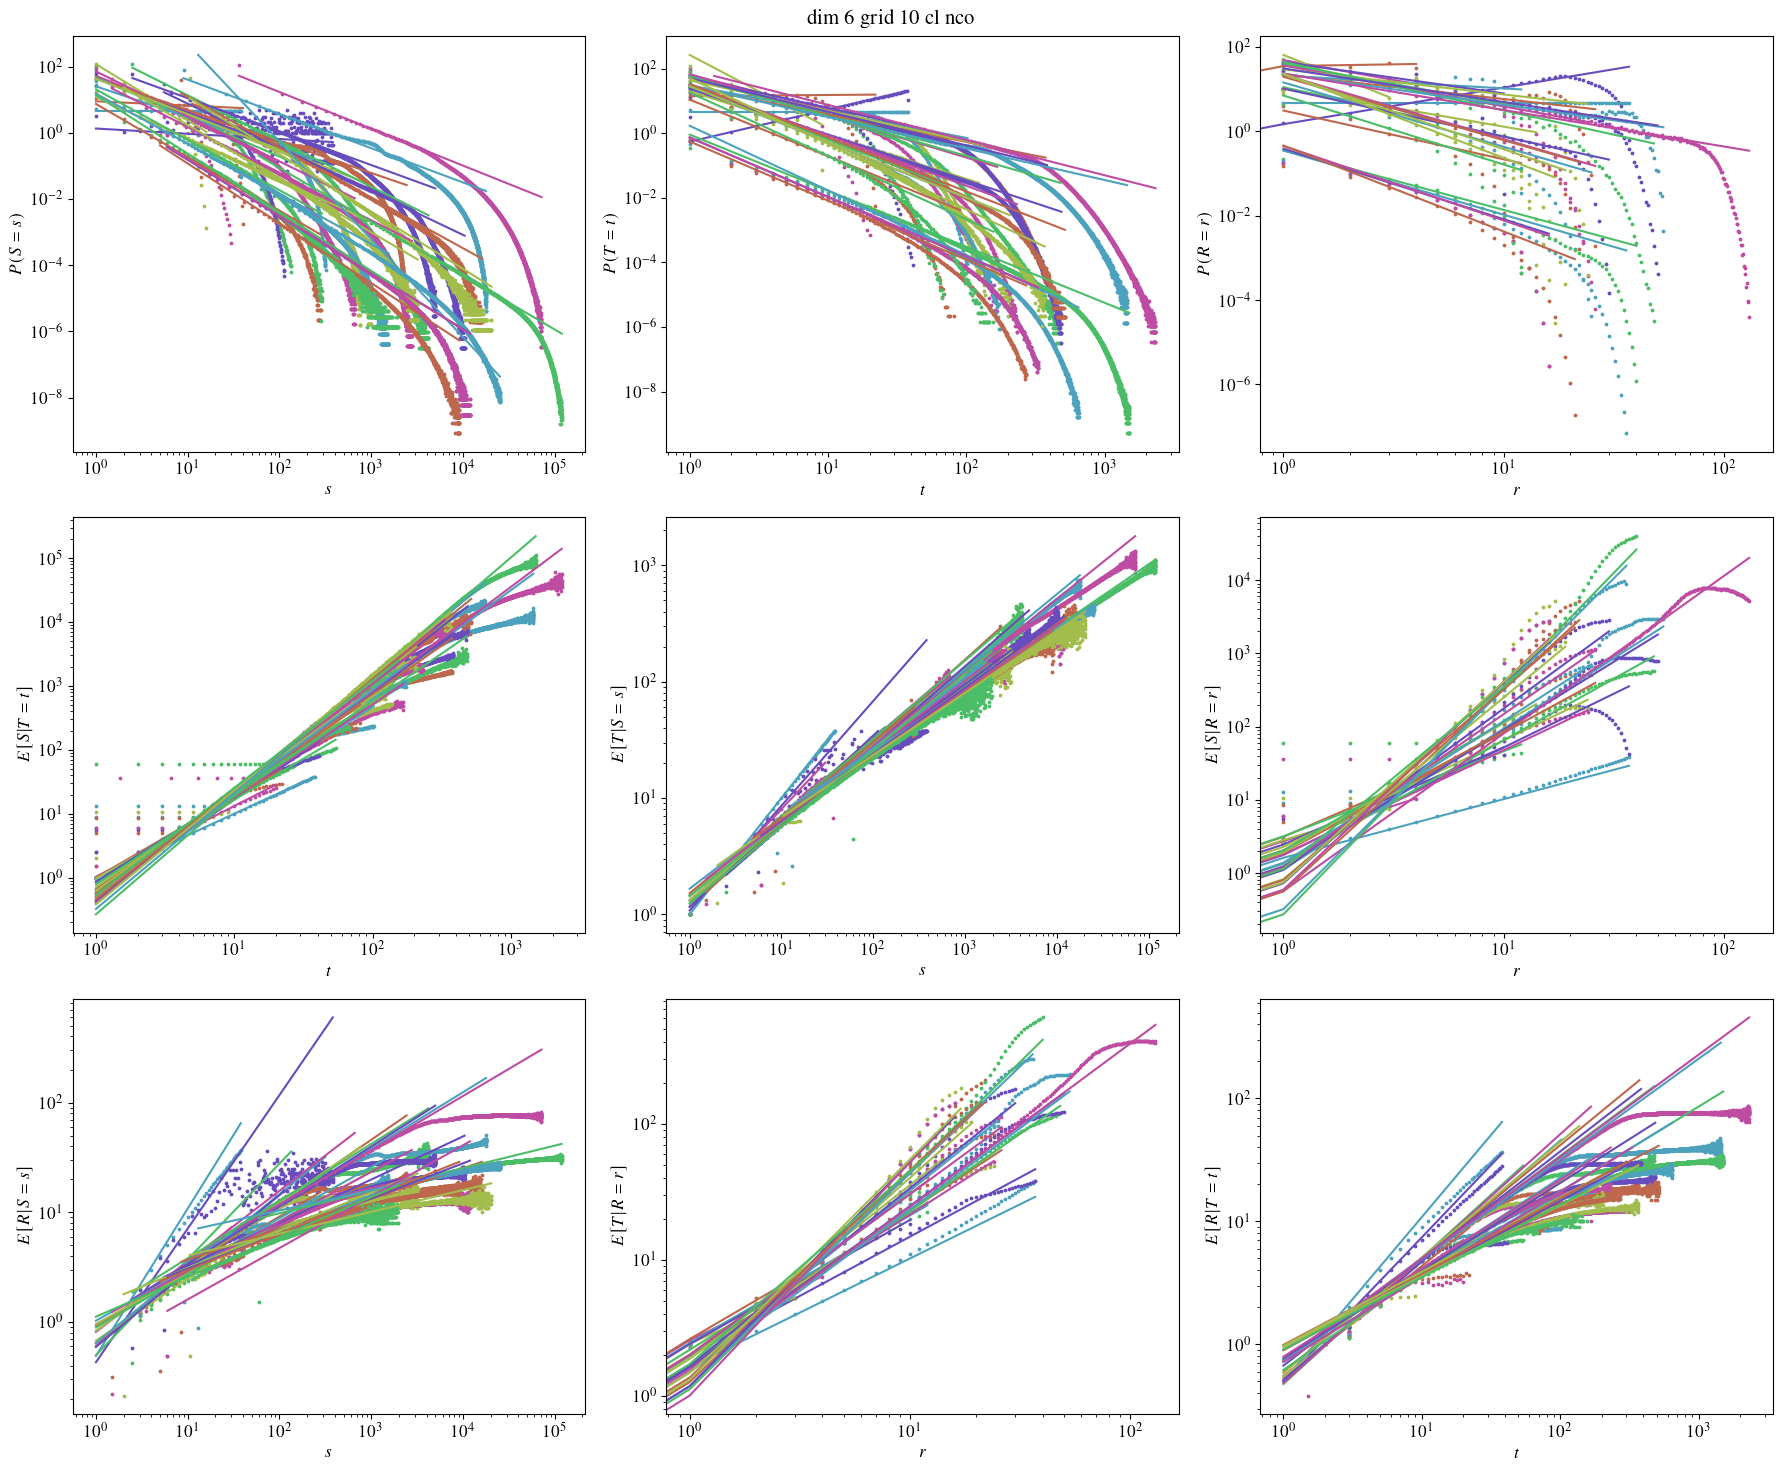

In [56]:
import matplotlib.pyplot as plt

from analysis import plot_scaling_exponents
from computation import *
import json
import pathlib
import pandas as pd

fig, ax = plt.subplots(3,3, figsize=(18, 15))
data_dir = pathlib.Path("data")
with open("scaling_exponents.json", "r") as f:
    meta = json.load(f)

# if specified, calculate scaling exponents for only one data set
do_plot = False
if isinstance(meta[0], int):
    meta = [meta[meta[0]]]
    do_plot = True
do_plot = True
# meta = [meta[0]]
df = pd.DataFrame()
for m in meta:
    if not (data_dir / m["path"] / "avalanche_distribution.npz").exists():
        print(f"no avalanche distribution for {m['path']}")
        try:
            clean_up_directory(data_dir / m["path"])
        except:
            pass
        continue
    (s, t, r), bins = load_3d_dist(data_dir / m["path"] / "avalanche_distribution.npz")
    fig.suptitle(m["label"])
    _df = plot_scaling_exponents(s, t, r, bins, ax, pathlib.Path(m["path"]).name,
                                m.get("limits", None), do_plot)
    df = pd.concat([df, _df])
df = df.sort_values(["dimension", "grid", "relax"]).query("grid > 5")
df = df.map(lambda x: "{:.2uS}".format(x) if isinstance(x, unc.core.AffineScalarFunc) else x)
df.to_csv(data_dir / "scaling_exponents.csv", index=False)
df

In [38]:
# import uncertainties as unc
# df.query("grid != 5 and relax == 'cl nco'", inplace=True)
# df.drop("relax", axis=1, inplace=True)
# df = df.map(lambda x: "{:.2uS}".format(x) if isinstance(x, unc.core.AffineScalarFunc) else x)
# df_new = df.sort_values(["dimension", "grid"])
# df_new.reset_index(level='relax', inplace=True)
# df_new.drop("relax", axis=0, inplace=True)
# df_new["relax"]
# df_new.drop("relax", inplace=True)
# df_new


In [127]:
df_table = df.map(lambda x: "{:.2uS}".format(x) if isinstance(x, unc.core.AffineScalarFunc) else x)
header = [
    "Dimension",
    "Grid",
    r"$\tau$",
    r"$\alpha$",
    r"$\lambda$",
    r"$\gamma_1$",
    r"$1/\gamma_1$",
    r"$\gamma_2$",
    r"$1/\gamma_2$",
    r"$\gamma_3$",
    r"$1/\gamma_3$",
]
# df_table.to_latex(
#     "tables/scaling_exponents_cl_nco.tex",
#     index=False,
#     escape=False,
#     header=header,
#     column_format=r"rr|ccccccccc",
# )


In [55]:
import uncertainties as unc
df_comp = df.copy()

df_comp["1/gamma1 inv"] = 1 / df["1/gamma1"]
df_comp["1/gamma2 inv"] = 1 / df["1/gamma2"]
df_comp["1/gamma3 inv"] = 1 / df["1/gamma3"]
df_comp["gamma2_new"] = df["gamma1"] * df["gamma3"]
# df_comp["alpha_new"] = 2 + (df["lambda"] - 2) / df["gamma3"]
df_comp["lambda1"] = (df["alpha"] - 2)* df["gamma3"] + 2
df_comp["lambda2"] = (df["tau"] - 2)* df["gamma2"] + 2
# df_comp["tau_new"] = 2 + (df["lambda"] - 2) / df["gamma2"]
df_comp.drop(columns=["1/gamma1", "1/gamma2", "1/gamma3"], inplace=True)
df_comp = df_comp[
    [
        "dimension",
        "grid",
        "lambda",
        # "alpha",
        "lambda1",
        # "tau",
        "lambda2",
        "gamma1",
        "1/gamma1 inv",
        "gamma2",
        "1/gamma2 inv",
        "gamma2_new",
        "gamma3",
        "1/gamma3 inv",
    ]
]
header = [
    "Dimension",
    "Grid",
    # r"$\alpha$",
    # r"$2 + (\lambda - 2)/\gamma_3$",  # alpha_new
    # r"$\tau$",
    # r"$2 + (\lambda - 2)/\gamma_2$",  # tau_new
    r"$\lambda$",
    r"$(\alpha - 2)\gamma_2 + 2$",
    r"$(\tau - 2)\gamma_3 + 2$",
    r"$\gamma_1$",
    r"$(1/\gamma_1)^{{-1}}$",
    r"$\gamma_2$",
    r"$(1/\gamma_2)^{{-1}}$",
    r"$\gamma_1 \gamma_3$",
    r"$\gamma_3$",
    r"$(1/\gamma_3)^{{-1}}$",
]
df_comp = df_comp.map(lambda x: "{:.2uS}".format(x) if isinstance(x, unc.core.AffineScalarFunc) else x)
# df_comp.to_latex(
#     "tables/scaling_exponents_comparison_cl_nco.tex",
#     header=header,
#     index=False,
#     escape=False,
#     column_format=r"rr|ccccccccccc",
# )
df_comp.to_csv(data_dir / "scaling_exponents_comparison.csv", index=False)
df_comp


,dimension,grid,lambda,lambda1,lambda2,gamma1,1/gamma1 inv,gamma2,1/gamma2 inv,gamma2_new,gamma3,1/gamma3 inv
0,1,40,0.132(41),0.26(16),0.76(55),1.48(37),1.110(58),1.47(24),0.821(44),1.29(35),0.873(83),0.851(77)
0,1,40,1.000005(30),1.20(11),1.20(12),1.0000000000009(99),0.9999999999991(99),0.80(12),0.74(14),0.80(11),0.80(11),0.75(15)
0,2,10,1.75(40),1.953(30),2.048(30),1.36(11),1.36(13),1.33(19),1.45(13),1.24(12),0.914(44),1.037(58)
0,2,10,1.94(42),2.178(18),2.224(36),1.282(74),1.476(36),1.16(18),1.145(37),1.29(10),1.006(54),0.975(48)
0,2,10,1.31(29),1.826(15),1.870(50),1.37(11),1.466(24),1.82(65),1.47(13),1.29(14),0.940(68),1.026(25)
0,2,20,1.60(36),1.939(13),2.100(16),1.4903(55),1.4908(73),1.45(19),1.722(79),1.635(66),1.097(44),1.06(13)
0,2,20,1.97(39),2.303(92),2.51(23),1.448(11),1.481(26),1.43(29),1.55(28),1.50(16),1.03(11),0.988(45)
0,2,20,1.58(35),1.842(26),1.922(12),1.5257(38),1.411(87),1.639(63),1.74(14),1.63(22),1.07(15),1.08(11)
0,2,40,1.795(54),2.05(17),2.019(19),1.5716(26),1.451(71),1.862(40),1.87(12),1.868(40),1.188(25),1.15(13)
0,2,40,2.15(15),2.260(46),2.64(14),1.485(19),1.483(46),1.68(10),1.920(72),1.684(99),1.134(65),1.200(56)
